## Image Embeddings

### Preface

**Summary**
- TBD

**Acknowledgements**
- Dataset: https://www.tensorflow.org/datasets/catalog/tf_flowers
- Blog Article: https://rom1504.medium.com/image-embeddings-ed1b194d113e
- Code Repo: https://github.com/rom1504/image_embeddings
- Code File: https://github.com/rom1504/image_embeddings/blob/master/notebooks/from_scratch.ipynb

### Initialization

**Packages**

In [128]:
import numpy as pkg_num
import os as pkg_os
import time as pkg_time
import math as pkg_math
import warnings as pkg_warnings
import matplotlib.pyplot as pkg_mplot
import matplotlib.image as pkg_mp_image
import pathlib as pkg_pathlib
import shutil as pkg_shutil

In [129]:
# Miscellaneous
%matplotlib inline
pkg_warnings.filterwarnings(action="ignore")

# Tensor Flow is optimized for CUDA-GPU
# That error goes away with following setting
# TODO: Figure out why the error goes away with this setting!
pkg_os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [130]:
import absl.logging as pkg_logging
import IPython.display as pkg_disp
import ipywidgets as pkg_widgets
import PIL as pkg_pil
import PIL.Image as pkg_pil_image
import pyarrow as pkg_arrow
import pyarrow.parquet as pkg_parquet
import tensorflow as pkg_tf
import tensorflow_datasets as pkg_tfds
import tensorflow_datasets.core.dataset_utils as pkg_tfds_utils
import tensorflow_datasets.core.features as pkg_tfds_features
import efficientnet as pkg_effinet
import efficientnet.preprocessing as pkg_effinet_preprocessing
import efficientnet.tfkeras as pkg_tfkeras
from efficientnet.tfkeras import EfficientNetB0 as EfficientNetRef

**Common**

In [131]:
# Performance related settings
AUTOTUNE = pkg_tf.data.AUTOTUNE

# Image Size (Target)
image_height = 180
image_width = 180
image_size = (image_height, image_width)

# Batch Size
batch_size = 32

# Path stuff
repo_root_dirpath = pkg_pathlib.Path.cwd().parent
temp_root_dirpath = repo_root_dirpath.joinpath(".outputs")
temp_flowers_ds_dirpath = temp_root_dirpath.joinpath(".datasets/tf_flowers")

folder_name_downloads = "downloads"
temp_downloads_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_downloads)

folder_name_images = "images"
temp_images_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_images)

folder_name_tfrecords = "tfrecords"
temp_tfrecords_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_tfrecords)

folder_name_embeddings = "embeddings"
temp_embeddings_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_embeddings)

temp_dirpaths = {
    folder_name_downloads: temp_downloads_dirpath,
    folder_name_images : temp_images_dirpath,
    folder_name_tfrecords: temp_tfrecords_dirpath,
    folder_name_embeddings : temp_embeddings_dirpath
}

In [132]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [133]:
def configure_for_batch_performance(ds):
  ds = configure_for_performance(ds)
  ds = ds.batch(batch_size=batch_size)
  return ds

In [134]:
def recreate_dirpath(dirpath):
    # (Re)create the data directory
    pkg_shutil.rmtree(dirpath, ignore_errors=True)
    dirpath.mkdir(parents=True, exist_ok=False)
    return dirpath

In [135]:
def recreate_folder(folder_name):
    return recreate_dirpath(temp_dirpaths[folder_name])

In [136]:
def folder_stats(folder_name):
    return temp_dirpaths[folder_name].stat()

**Load Data**

In [137]:
def download_dataset(dataset_name, data_dirpath):
    ds, ds_info = pkg_tfds.load(name=dataset_name, data_dir=data_dirpath, 
        split='train', with_info=True)
    return ds, ds_info

def save_examples(ds, ds_info, data_dirpath, num_examples = 10, image_key=None):
  """Save images from an image classification dataset.

  Only works with datasets that have 1 image feature and optionally 1 label
  feature (both inferred from `ds_info`). Note the dataset should be unbatched.

  Usage:

  ```python
  ds, ds_info = tfds.load('cifar10', split='train', with_info=True)
  fig = save_examples(ds, ds_info, data_dir)
  ```

  Args:
    ds: `tf.data.Dataset`. The tf.data.Dataset object to visualize. Examples
      should not be batched.
    num_examples: `int`. Number of examples to save
    ds_info: The dataset info object to which extract the label and features
      info. Available either through `tfds.load('mnist', with_info=True)` or
      `tfds.builder('mnist').info`
    data_dir: `pathlib.Path`. Where to save images
    image_key: `string`, name of the feature that contains the image. If not
       set, the system will try to auto-detect it.

  Returns:
  """

  if not image_key:
    # Infer the image and label keys
    image_keys = [
        k for k, feature in ds_info.features.items()
        if isinstance(feature, pkg_tfds_features.Image)
    ]

    if not image_keys:
      raise ValueError(
          "Visualisation not supported for dataset `{}`. Was not able to "
          "auto-infer image.".format(ds_info.name))

    if len(image_keys) > 1:
      raise ValueError(
          "Multiple image features detected in the dataset. Using the first one. You can "
          "use `image_key` argument to override. Images detected: %s" %
          (",".join(image_keys)))

    image_key = image_keys[0]

  label_keys = [
      k for k, feature in ds_info.features.items()
      if isinstance(feature, pkg_tfds_features.ClassLabel)
  ]

  label_key = label_keys[0] if len(label_keys) == 1 else None
  if not label_key:
    pkg_logging.info("Was not able to auto-infer label.")

  examples = list(pkg_tfds_utils.as_numpy(ds.take(num_examples)))
  
  # Save the images as files on disk
  for i, ex in enumerate(examples):
    if not isinstance(ex, dict):
      raise ValueError(
          "tensorflow_datasets.show_examples requires examples as `dict`, with the same "
          "structure as `ds_info.features`. It is currently not compatible "
          "with `as_supervised=True`. Received: {}".format(type(ex)))

    # Plot the image
    image = ex[image_key]
    if len(image.shape) != 3:
      raise ValueError(
          "Image dimension should be 3. tensorflow_datasets.show_examples does not support "
          "batched examples or video.")
    _, _, c = image.shape
    if c == 1:
      image = image.reshape(image.shape[:2])
    image = pkg_effinet_preprocessing.center_crop_and_resize(image, 224).astype(pkg_num.uint8)
    im = pkg_pil_image.fromarray(image)
    # Plot the label
    if label_key:
      label = ex[label_key]
      label_str = ds_info.features[label_key].int2str(label)
    else:
      label_str = ""
    filepath = data_dirpath.joinpath("image_{:04d}_{}.jpeg".format(i, label_str))
    im.save(filepath)

In [138]:
def download_and_save_flowers_dataset(example_count):
    ds, ds_info = download_dataset("tf_flowers", temp_downloads_dirpath)
    recreate_dirpath(temp_images_dirpath)
    save_examples(ds, ds_info, temp_images_dirpath, example_count)
    print("Directory Stats ({}) : {}".format(folder_name_images, folder_stats(folder_name_images)))
    ds = configure_for_performance(ds)
    fig = pkg_tfds.show_examples(ds, ds_info)
    return ds, ds_info

### Transform

**Routines**

In [139]:
def list_files(folder_name, pattern="*", shuffle=False):
    dirpath = temp_dirpaths[folder_name].as_posix()
    return pkg_tf.data.Dataset.list_files(dirpath + "/" + pattern, shuffle=shuffle)

def process_path(file_path):
    parts = pkg_tf.strings.split(file_path, '/')
    image_name = pkg_tf.strings.split(parts[-1], '.')[0]
    raw = pkg_tf.io.read_file(file_path)
    return raw, image_name


def read_data_from_files(list_ds):
    return list_ds.map(process_path,
        num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE)#.apply(pkg_tf.data.experimental.ignore_errors())


def images_to_embeddings(model, dataset, batch_size):
    return model.predict(dataset.batch(batch_size).map(lambda image_raw, image_name: image_raw), verbose=1)


def save_embeddings_ds_to_parquet(embeddings, dataset, path):
    embeddings = pkg_arrow.array(embeddings.tolist(), type=pkg_arrow.list_(pkg_arrow.float32()))
    image_names = pkg_arrow.array(dataset.map(lambda image_raw, image_name: image_name).as_numpy_iterator())
    table = pkg_arrow.Table.from_arrays([image_names, embeddings], ["image_name", "embedding"])
    pkg_parquet.write_table(table, path)


def compute_save_embeddings(input_folder_name, output_folder_name, num_shards, model, batch_size):
    start = pkg_time.time()
    list_ds = list_files(input_folder_name, "*.jpeg").cache()

    output_dirpath = temp_dirpaths[output_folder_name]
    for shard_id in range(0, num_shards):
        shard_list = list_ds.shard(num_shards=num_shards, index=shard_id)
        shard = read_data_from_files(shard_list)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("Shard " + str(shard_id) + " done after " + str(int(pkg_time.time() - start)) + "s")
        output_filepath = output_dirpath.joinpath("part-{:04d}.parquet".format(shard_id))
        save_embeddings_ds_to_parquet(embeddings, shard, output_filepath)
        print("Shard " + str(shard_id) + " saved after " + str(int(pkg_time.time() - start)) + "s")
    print("Total time : " + str(int(pkg_time.time() - start)))


def infer_images(input_folder_name, output_folder_name, num_shards=100, batch_size=1000):
    model = EfficientNetRef(weights='imagenet', include_top=False, pooling="avg")
    compute_save_embeddings(input_folder_name, output_folder_name, num_shards, model, batch_size)

In [140]:
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return pkg_tf.train.Feature(int64_list=pkg_tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(pkg_tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return pkg_tf.train.Feature(bytes_list=pkg_tf.train.BytesList(value=[value]))


def serialize_example(image, image_name):
    feature = {
        'image_name': _bytes_feature(image_name),
        'image_data': _bytes_feature(image)
    }

    example_proto = pkg_tf.train.Example(features=pkg_tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def tf_serialize_example(image, image_name):
    tf_string = pkg_tf.py_function(
        serialize_example,
        (image, image_name),
        pkg_tf.string)
    return pkg_tf.reshape(tf_string, ())


def process_path(file_path):
    parts = pkg_tf.strings.split(file_path, '/')
    image_name = pkg_tf.strings.split(parts[-1], '.')[0]
    raw = pkg_tf.io.read_file(file_path)
    return raw, image_name


def read_image_file_write_tfrecord(files_ds, output_filepath):
    image_ds = files_ds.map(process_path, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE)
    serialized_features_dataset = image_ds.map(tf_serialize_example, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE)
    writer = pkg_tf.data.experimental.TFRecordWriter(output_filepath.as_posix())
    writer.write(serialized_features_dataset)


def image_files_to_tfrecords(image_folder_name, output_folder_name, num_shard):
    list_ds = list_files(image_folder_name, "*.jpeg")
    output_dirpath = temp_dirpaths[output_folder_name]
    start = pkg_time.time()
    for shard_id in range(0, num_shard):
        shard_list = list_ds.shard(num_shards=num_shard, index=shard_id)
        output_filepath = output_dirpath.joinpath("part-{:04d}.tfrecord".format(shard_id))
        read_image_file_write_tfrecord(shard_list, output_filepath)
        print("Shard " + str(shard_id) + " saved after " + str(int(pkg_time.time() - start)) + "s")


def _parse_function(example_proto):
    feature_description = {
        'image_name': pkg_tf.io.FixedLenFeature([], pkg_tf.string),
        'image_data': pkg_tf.io.FixedLenFeature([], pkg_tf.string)
    }
    return pkg_tf.io.parse_single_example(example_proto, feature_description)


def preprocess_image(d):
    image_name = d['image_name']
    raw = d['image_data']
    image = pkg_tf.image.decode_jpeg(raw)
    image = pkg_tf.image.convert_image_dtype(image, pkg_tf.float32)

    return image, image_name


def read_tfrecord(filepath):
    raw_dataset =  pkg_tf.data.TFRecordDataset(filenames=[filepath])
    return raw_dataset \
        .map(_parse_function, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE) \
        .map(preprocess_image, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE) \
        .apply(pkg_tf.data.experimental.ignore_errors())


def tfrecords_to_embeddings(input_folder_name, output_folder_name, model, batch_size):
    tfrecords = [f.numpy().decode("utf-8") for f in list_files(input_folder_name, "*.tfrecord")]
    start = pkg_time.time()
    output_dirpath = temp_dirpaths[output_folder_name]
    for shard_id, tfrecord in enumerate(tfrecords):
        shard = read_tfrecord(tfrecord)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("Shard " + str(shard_id) + " done after " + str(int(pkg_time.time() - start)) + "s")
        output_filepath = output_dirpath.joinpath("part-{:04d}.parquet".format(shard_id))
        save_embeddings_ds_to_parquet(embeddings, shard, output_filepath)
        print("Shard " + str(shard_id) + " saved after " + str(int(pkg_time.time() - start)) + "s")

**Models**

In [141]:
def calculate_and_save_embeddings_flowers_dataset(shard_count):
    recreate_folder(folder_name_tfrecords)
    image_files_to_tfrecords(folder_name_images, folder_name_tfrecords, shard_count)
    print("Directory Stats ({}) : {}".format(folder_name_tfrecords, folder_stats(folder_name_tfrecords)))

    recreate_folder(folder_name_embeddings)
    model = EfficientNetRef(weights='imagenet', include_top=False, pooling="avg")
    tfrecords_to_embeddings(folder_name_tfrecords, folder_name_embeddings, model, batch_size)
    print("Directory Stats ({}) : {}".format(folder_name_embeddings, folder_stats(folder_name_embeddings)))


### Main

**Process**

2022-08-20 23:18:40.133026: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Directory Stats (images) : os.stat_result(st_mode=16877, st_ino=282040, st_dev=2112, st_nlink=2, st_uid=1000, st_gid=1000, st_size=114688, st_atime=1661017794, st_mtime=1661017962, st_ctime=1661017962)


2022-08-20 23:22:43.146985: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-20 23:22:43.148971: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


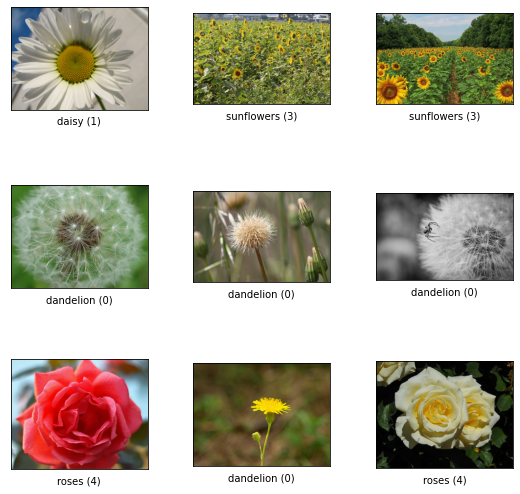

Shard 0 saved after 0s
Shard 1 saved after 0s
Shard 2 saved after 1s
Shard 3 saved after 1s
Shard 4 saved after 1s
Shard 5 saved after 2s
Shard 6 saved after 2s
Shard 7 saved after 2s
Shard 8 saved after 2s
Shard 9 saved after 3s
Directory Stats (tfrecords) : os.stat_result(st_mode=16877, st_ino=354770, st_dev=2112, st_nlink=2, st_uid=1000, st_gid=1000, st_size=4096, st_atime=1661017963, st_mtime=1661017966, st_ctime=1661017966)
7/7 [==============================] - 8s 930ms/step
Shard 0 done after 7s
Shard 0 saved after 8s
7/7 [==============================] - 6s 817ms/step
Shard 1 done after 14s
Shard 1 saved after 14s
7/7 [==============================] - 6s 847ms/step
Shard 2 done after 20s
Shard 2 saved after 20s
7/7 [==============================] - 6s 886ms/step
Shard 3 done after 27s
Shard 3 saved after 27s
7/7 [==============================] - 6s 802ms/step
Shard 4 done after 33s
Shard 4 saved after 33s
7/7 [==============================] - 6s 827ms/step
Shard 5 done aft

In [142]:
download_and_save_flowers_dataset(example_count=2000)
calculate_and_save_embeddings_flowers_dataset(shard_count = 10)